In [29]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Библиотеки для машинного обучения
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Библиотеки для нейронных сетей
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print("TensorFlow версия:", tf.__version__)
except ImportError:
    print("TensorFlow не установлен. Установите: pip install tensorflow")

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Все библиотеки успешно импортированы!")


TensorFlow версия: 2.20.0
Все библиотеки успешно импортированы!


In [ ]:
# Путь к CSV файлам (относительно корня проекта Laravel)
import os

# Определяем путь к папке с CSV файлами
csv_dir = 'D:/Учёба/КурсоваяКПО/KPO/storage/app/private/securities/'

# Функция для загрузки данных тикера
def load_ticker_data(ticker, csv_directory=csv_dir):
    """
    Загружает данные тикера из CSV файла
    
    Параметры:
    ticker: строка с тикером (например, 'SBER')
    csv_directory: путь к папке с CSV файлами
    
    Возвращает:
    DataFrame с колонками: ticker, time, open, high, low, close, volume
    """
    file_path = os.path.join(csv_directory, f"{ticker.upper()}.csv")
    
    if not os.path.exists(file_path):
        print(f"Файл {file_path} не найден!")
        return None
    
    try:
        # Читаем CSV файл (используем заголовок из файла)
        df = pd.read_csv(file_path)
        
        # Убеждаемся, что колонки имеют правильные имена
        expected_columns = ['ticker', 'time', 'open', 'high', 'low', 'close', 'volume']
        
        # Нормализуем названия колонок (убираем пробелы, приводим к нижнему регистру)
        df.columns = [col.strip() for col in df.columns]
        current_columns_lower = [col.lower() for col in df.columns]
        expected_columns_lower = [col.lower() for col in expected_columns]
        
        # Если колонки уже правильные (возможно в другом порядке)
        if set(current_columns_lower) == set(expected_columns_lower):
            # Создаем маппинг для переименования колонок в правильный порядок
            column_mapping = {}
            for expected_col in expected_columns:
                # Находим соответствующую колонку в текущих колонках
                for current_col in df.columns:
                    if current_col.lower() == expected_col.lower():
                        column_mapping[current_col] = expected_col
                        break
            
            df = df.rename(columns=column_mapping)
            df = df[expected_columns]  # Переупорядочиваем колонки
        else:
            # Колонки не совпадают - возможно первая строка содержит заголовок
            # Проверяем количество колонок
            if len(df.columns) == len(expected_columns):
                # Проверяем первую строку данных
                if len(df) > 0:
                    first_row_str = [str(val).strip().lower() for val in df.iloc[0].values]
                    # Если первая строка выглядит как заголовок
                    if first_row_str == expected_columns_lower or 'ticker' in first_row_str:
                        # Удаляем первую строку и устанавливаем правильные названия
                        df = df.drop(df.index[0]).reset_index(drop=True)
                # Устанавливаем правильные названия колонок
                df.columns = expected_columns
            else:
                raise ValueError(f"Неожиданное количество колонок в CSV: {len(df.columns)}, ожидалось {len(expected_columns)}")
        
        # Финальная проверка: удаляем строку заголовка, если она все еще есть в данных
        if len(df) > 0:
            try:
                first_value = str(df.iloc[0]['ticker']).strip().lower()
                if first_value == 'ticker':
                    df = df.drop(df.index[0]).reset_index(drop=True)
            except (KeyError, IndexError):
                pass  # Игнорируем ошибки при проверке
        
        # Проверяем, что DataFrame не пустой и содержит нужные колонки
        if df.empty:
            raise ValueError(f"CSV файл {file_path} пуст после обработки")
        
        if 'ticker' not in df.columns:
            raise ValueError(f"CSV файл {file_path} не содержит колонку 'ticker'")
        
        # Преобразуем время в datetime
        df['time'] = pd.to_datetime(df['time'])
        
        # Сортируем по времени
        df = df.sort_values('time').reset_index(drop=True)
        
        # Удаляем дубликаты
        df = df.drop_duplicates(subset=['time'], keep='last')
        
        print(f"Загружено {len(df)} записей для тикера {ticker.upper()}")
        print(f"Период: {df['time'].min()} - {df['time'].max()}")
        
        return df
    except Exception as e:
        print(f"Ошибка при загрузке {file_path}: {e}")
        return None

ticker = 'SBER'
df = load_ticker_data(ticker)

if df is not None:
    print("\nПервые 5 строк:")
    print(df.head())
    print("\nИнформация о данных:")
    print(df.info())
    print("\nСтатистика:")
    print(df.describe())


Загружено 570 записей для тикера SBER
Период: 2023-12-18 00:00:00 - 2025-12-16 00:00:00

Первые 5 строк:
  ticker       time    open    high     low   close    volume
0   SBER 2023-12-18  268.93  270.44  266.54  268.40  51602470
1   SBER 2023-12-19  268.38  269.71  265.00  267.35  38287810
2   SBER 2023-12-20  267.51  269.10  266.20  266.61  31094000
3   SBER 2023-12-21  266.40  266.87  263.50  265.19  33301420
4   SBER 2023-12-22  266.06  271.90  265.37  271.30  58724860

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ticker  570 non-null    object        
 1   time    570 non-null    datetime64[ns]
 2   open    570 non-null    float64       
 3   high    570 non-null    float64       
 4   low     570 non-null    float64       
 5   close   570 non-null    float64       
 6   volume  570 non-null    int64         
d

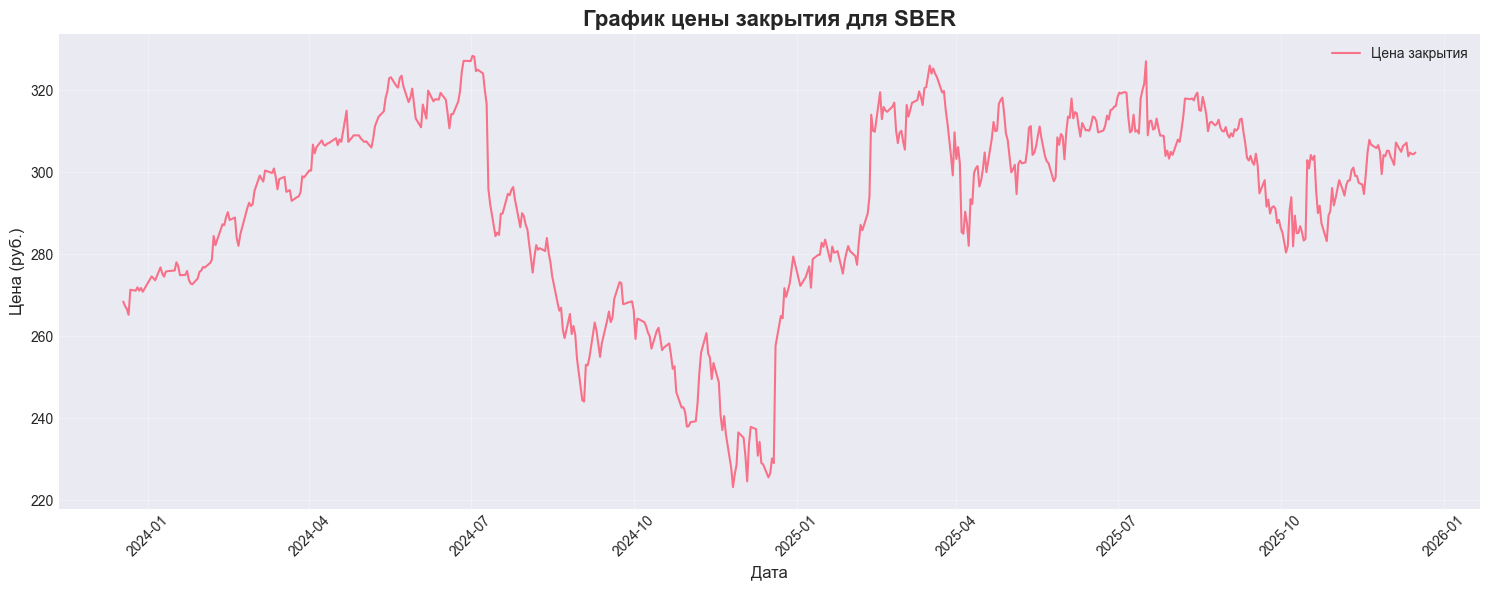

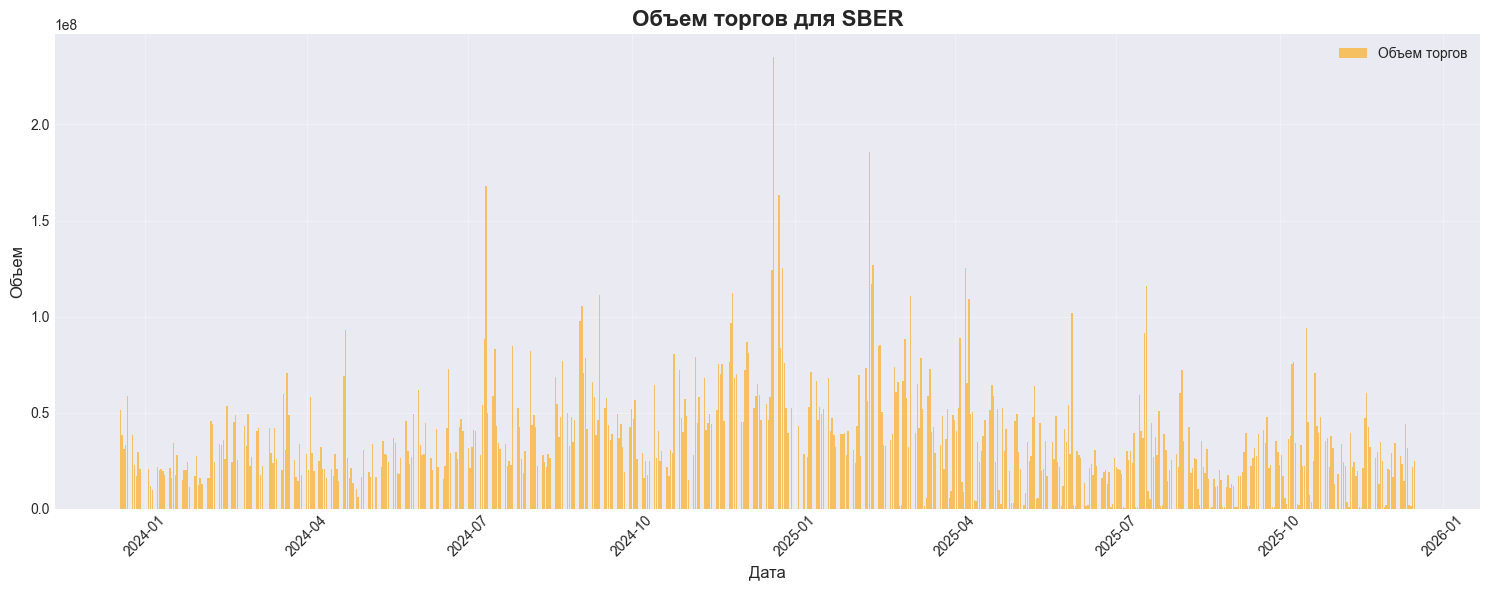

In [ ]:
if df is not None:
    plt.figure(figsize=(15, 6))
    plt.plot(df['time'], df['close'], label='Цена закрытия', linewidth=1.5)
    plt.title(f'График цены закрытия для {ticker.upper()}', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Цена (руб.)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plt.bar(df['time'], df['volume'], alpha=0.6, color='orange', label='Объем торгов')
    plt.title(f'Объем торгов для {ticker.upper()}', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Объем', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


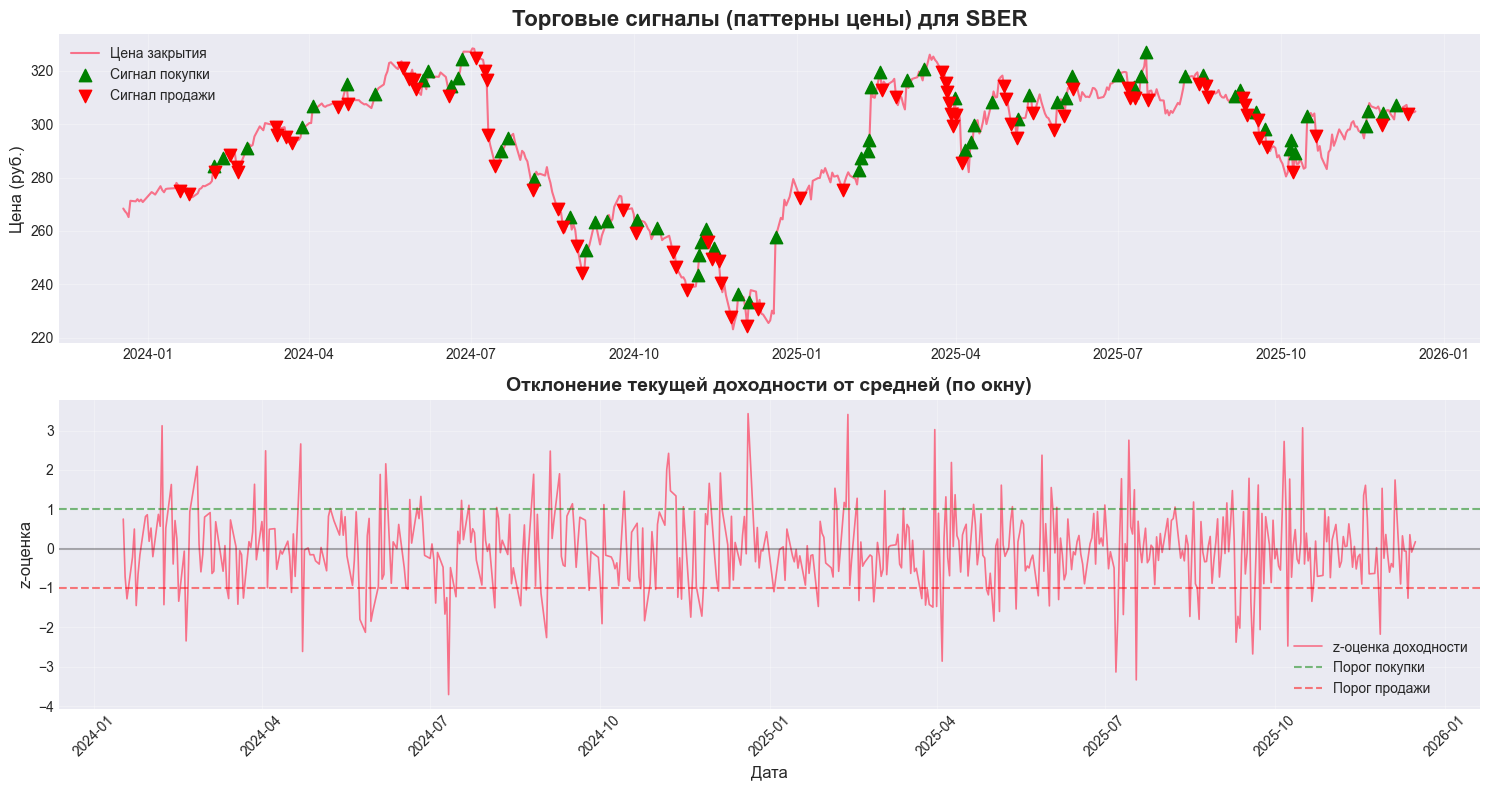


Статистика торговых сигналов (только по цене):
Сигналов покупки: 65
Сигналов продажи: 76
Сигналов удержания: 429


In [ ]:

def generate_trading_signals(df, lookback: int = 20, z_threshold: float = 1.0):

    prices = df['close'].astype(float)
    returns = prices.pct_change()

    mean_ret = returns.rolling(lookback).mean()
    vol_ret = returns.rolling(lookback).std()

    zscore = (returns - mean_ret) / vol_ret.replace(0, np.nan)

    signals = pd.DataFrame(index=df.index)
    signals['price'] = prices
    signals['zscore'] = zscore
    signals['signal'] = 0
    signals['position'] = 0

    signals.loc[signals['zscore'] > z_threshold, 'signal'] = 1
    signals.loc[signals['zscore'] < -z_threshold, 'signal'] = -1

    signals.loc[signals['signal'] == 1, 'position'] = 1 
    signals.loc[signals['signal'] == -1, 'position'] = -1 

    return signals

if df is not None:
    signals = generate_trading_signals(df, lookback=20, z_threshold=1.0)

    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.plot(df['time'], df['close'], label='Цена закрытия', linewidth=1.5)

    buy_signals = signals[signals['position'] == 1]
    sell_signals = signals[signals['position'] == -1]

    plt.scatter(df.loc[buy_signals.index, 'time'], buy_signals['price'],
                marker='^', color='green', s=80, label='Сигнал покупки', zorder=5)
    plt.scatter(df.loc[sell_signals.index, 'time'], sell_signals['price'],
                marker='v', color='red', s=80, label='Сигнал продажи', zorder=5)

    plt.title(f'Торговые сигналы (паттерны цены) для {ticker.upper()}', fontsize=16, fontweight='bold')
    plt.ylabel('Цена (руб.)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(df['time'], signals['zscore'], label='z-оценка доходности', linewidth=1.2)
    plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Порог покупки')
    plt.axhline(y=-1.0, color='red', linestyle='--', alpha=0.5, label='Порог продажи')
    plt.axhline(y=0.0, color='black', linestyle='-', alpha=0.3)

    plt.title('Отклонение текущей доходности от средней (по окну)', fontsize=14, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('z-оценка', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("\nСтатистика торговых сигналов (только по цене):")
    print(f"Сигналов покупки: {len(buy_signals)}")
    print(f"Сигналов продажи: {len(sell_signals)}")
    print(f"Сигналов удержания: {len(signals[signals['position'] == 0])}") 

In [ ]:

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import pickle


def prepare_pattern_data(df, lookback: int = 60, forecast_days: int = 1):

    df_close = df[['close']].dropna().reset_index(drop=True)

    if len(df_close) < lookback + forecast_days:
        print(f"Недостаточно данных для паттернов: нужно минимум {lookback + forecast_days}, есть {len(df_close)}")
        return None, None, None

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df_close.values)

    X, y = [], []
    for i in range(lookback, len(scaled) - forecast_days + 1):
        X.append(scaled[i - lookback:i])  
        y.append(scaled[i + forecast_days - 1, 0])

    X = np.asarray(X)
    y = np.asarray(y)

    print(f"Создано {len(X)} паттернов, форма X: {X.shape}, форма y: {y.shape}")
    return X, y, scaler


if df is not None:
    lookback = 60
    forecast_days = 1 

    X_pat, y_pat, scaler_pat = prepare_pattern_data(df, lookback=lookback, forecast_days=forecast_days)

    if X_pat is not None:
        split_idx = int(len(X_pat) * 0.8)
        X_train_pat, X_test_pat = X_pat[:split_idx], X_pat[split_idx:]
        y_train_pat, y_test_pat = y_pat[:split_idx], y_pat[split_idx:]

        print(f"Обучающая выборка (паттерны): {len(X_train_pat)}, тестовая: {len(X_test_pat)}")

        if 'create_lstm_model' in globals():
            model_pat = create_lstm_model((lookback, 1))
        else:
            from tensorflow.keras.models import Sequential
            from tensorflow.keras.layers import LSTM, Dense, Dropout

            model_pat = Sequential([
                LSTM(32, return_sequences=True, input_shape=(lookback, 1)),
                Dropout(0.3),
                LSTM(32, return_sequences=True),
                Dropout(0.3),
                LSTM(32),
                Dropout(0.3),
                Dense(1),
            ])
            model_pat.compile(optimizer='adam', loss='mse', metrics=['mae'])

        from tensorflow.keras.callbacks import EarlyStopping

        early_stopping_pat = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        history_pat = model_pat.fit(
            X_train_pat, y_train_pat,
            batch_size=32,
            epochs=80,
            validation_split=0.2,
            callbacks=[early_stopping_pat],
            verbose=1
        )

        os.makedirs('models', exist_ok=True)
        model_path_pat = f"models/lstm_patterns_{ticker.lower()}.h5"
        scaler_path_pat = f"models/scaler_patterns_{ticker.lower()}.pkl"

        model_pat.save(model_path_pat)
        with open(scaler_path_pat, 'wb') as f:
            pickle.dump(scaler_pat, f)

        print(f"Модель по паттернам сохранена в {model_path_pat}")
        print(f"Scaler по паттернам сохранён в {scaler_path_pat}")



Создано 510 паттернов, форма X: (510, 60, 1), форма y: (510,)
Обучающая выборка (паттерны): 408, тестовая: 102
Epoch 1/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.2158 - mae: 0.3913 - val_loss: 0.0056 - val_mae: 0.0617
Epoch 2/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0571 - mae: 0.1927 - val_loss: 0.0460 - val_mae: 0.2098
Epoch 3/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0403 - mae: 0.1668 - val_loss: 0.0031 - val_mae: 0.0451
Epoch 4/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0337 - mae: 0.1510 - val_loss: 0.0118 - val_mae: 0.0986
Epoch 5/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0317 - mae: 0.1470 - val_loss: 0.0145 - val_mae: 0.1109
Epoch 6/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0290 - mae: 0.1409 - val_loss: 0.0023 - val_mae: 0.0409
Epoch 7/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0284 - mae: 0.1397 - val_loss: 0.0033 - val_mae: 0.0463
Epoch 8/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0255 - m

Модель по паттернам сохранена в models/lstm_patterns_sber.h5
Scaler по паттернам сохранён в models/scaler_patterns_sber.pkl


In [ ]:


if df is not None and 'model_pat' in locals() and 'scaler_pat' in locals() \
   and 'X_test_pat' in locals() and 'y_test_pat' in locals():
    y_pred_scaled = model_pat.predict(X_test_pat, verbose=0)
    y_true_scaled = y_test_pat.reshape(-1, 1)               

    y_pred = scaler_pat.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler_pat.inverse_transform(y_true_scaled).flatten()

    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan

    print("\nТочность модели на тестовой выборке:")
    print(f"RMSE: {rmse:.2f} руб.")
    print(f"MAE:  {mae:.2f} руб.")
    if not np.isnan(mape):
        print(f"MAPE: {mape:.2f}%")
    else:
        print("MAPE: невозможно посчитать (нулевые реальные цены)")

    print("\nПоследние 5 точек теста:")
    for real, pred in list(zip(y_true, y_pred))[-5:]:
        print(f"Реальная: {real:.2f} руб.   Предсказанная: {pred:.2f} руб.")
else:
    print("Нет обученной модели или тестовых данных для оценки точности.")




Точность модели на тестовой выборке:
RMSE: 7.78 руб.
MAE:  5.92 руб.
MAPE: 2.01%

Последние 5 точек теста:
Реальная: 303.86 руб.   Предсказанная: 306.33 руб.
Реальная: 304.77 руб.   Предсказанная: 306.49 руб.
Реальная: 304.39 руб.   Предсказанная: 306.63 руб.
Реальная: 304.40 руб.   Предсказанная: 306.75 руб.
Реальная: 304.78 руб.   Предсказанная: 306.85 руб.


In [ ]:


if df is not None and 'model_pat' in locals() and 'scaler_pat' in locals() and 'X_pat' in locals():

    last_seq = X_pat[-1]
    current_seq = last_seq.copy()

    n_days = 365 
    current_price = float(df['close'].iloc[-1])
    future_price = current_price

    for _ in range(n_days):
        next_scaled = model_pat.predict(current_seq.reshape(1, current_seq.shape[0], current_seq.shape[1]), verbose=0)

        next_price = scaler_pat.inverse_transform(next_scaled.reshape(-1, 1))[0, 0]
        future_price = float(next_price)

        new_row = np.array([[next_scaled[0, 0]]]) 
        current_seq = np.vstack([current_seq[1:], new_row])

    print(f"Текущая цена: {current_price:.2f} руб.")
    print(f"Прогнозируемая цена через {n_days} дней: {future_price:.2f} руб.")
else:
    print("Нет обученной модели или данных для расчёта прогнозной цены.")



Текущая цена: 304.78 руб.
Прогнозируемая цена через 252 дней: 314.15 руб.
